1 Data collection and preprocessing

In [1]:
#!/usr/bin/env python
# coding: utf-8



get_ipython().system('pip install yfinance pandas numpy matplotlib requests')

import yfinance as yf
import pandas as pd
import numpy as np
import requests
import random


D:\ANACONDA\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
# 从维基百科获取标普500成分股列表
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(sp500_url, header=0)[0]
sp500_symbols = sp500_table['Symbol'].tolist()  # 获取所有股票代码


In [3]:
# 设置下载参数
start_date = "2014-01-01"
end_date = "2024-01-01"
frequency = "1mo"  # 月频 月频数据，适合因子分析，避免日频带来的计算复杂度
min_data_points = 84  # 至少7年（84个月）的数据点，因为很多股票是十年内的新股，所以我们要求股票至少有7年的数据，否则数据过少，影响准确度

# 随机选择初始股票池
random.seed(42)  # 固定随机种子以便结果可复现
initial_stocks = random.sample(sp500_symbols, 50) #随机抽50个股票

# 下载数据
price_data = {}
failed_stocks = []

for stock in initial_stocks:
    try:
        # 下载数据并检查有效性
        adjusted_ticker = stock.replace('.', '-')  # 处理带点号的股票
        data = yf.download(adjusted_ticker, start=start_date, end=end_date, interval=frequency)
        if len(data) >= min_data_points:  # 满足7年数据点条件
            price_data[stock] = data
        else:
            failed_stocks.append(stock)
    except Exception as e:
        failed_stocks.append(stock)
        print(f"Failed to download data for {stock}: {e}")

print(f"Initial valid stocks: {len(price_data)}")
print(f"Failed or short-term stocks: {len(failed_stocks)}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Initial valid stocks: 49
Failed or short-term stocks: 1


In [4]:
# 如果股票池少于50只，从剩余股票中补充
remaining_stocks = [stock for stock in sp500_symbols if stock not in price_data]
additional_stocks_needed = 50 - len(price_data)

if additional_stocks_needed > 0:
    additional_stocks = random.sample(remaining_stocks, additional_stocks_needed)
    for stock in additional_stocks:
        try:
            # 下载数据并检查有效性
            adjusted_ticker = stock.replace('.', '-')
            data = yf.download(adjusted_ticker, start=start_date, end=end_date, interval=frequency)
            if len(data) >= min_data_points:
                price_data[stock] = data
        except Exception as e:
            print(f"Failed to download data for {stock}: {e}")

print(f"Final valid stocks: {len(price_data)}")


[*********************100%%**********************]  1 of 1 completed

Final valid stocks: 50


In [6]:
# 创建一个字典存储收益率，避免建模价格，改为建模收益率 （为什么呢）
returns_data = {}

for stock, df in price_data.items():
    df['Monthly Return'] = df['Close'].pct_change()  # 计算月收益率
    returns_data[stock] = df['Monthly Return']

# 转换为单个DataFrame
returns_df = pd.DataFrame(returns_data)

# 保存收益率数据
returns_df.to_csv("monthly_returns.csv")
print("Monthly returns saved to 'monthly_returns.csv'")


Monthly returns saved to 'monthly_returns.csv'


In [7]:
import os

# 保存原始数据
data_dir = "stock_data"
os.makedirs(data_dir, exist_ok=True)

for stock, df in price_data.items():
    df.to_csv(os.path.join(data_dir, f"{stock}_raw_data.csv"))
print(f"All raw data saved in '{data_dir}' folder.")


All raw data saved in 'stock_data' folder.


In [8]:
import pandas as pd

# 文件路径（替换为你的文件路径） 在网上获取fama french 因子，然后选择三因子模型，简化模型，避免复杂度过高，使用少量核心风险因子。
file_path = "C:/Users/ROG/Desktop/machine learning/final project/F-F_Research_Data_Factors.CSV"

# 读取 CSV 文件（假设第一行是列名）
factors_df = pd.read_csv(file_path)

# 重命名第一列为 'Date'（日期列）
factors_df.rename(columns={factors_df.columns[0]: "Date"}, inplace=True)

# 转换日期格式（YYYYMM -> datetime）
factors_df['Date'] = pd.to_datetime(factors_df['Date'], format='%Y%m')

# 将日期设置为索引
factors_df.set_index('Date', inplace=True)

# 重命名其他列
factors_df.rename(columns={
    "Mkt-RF": "Market",  # 市场因子
    "SMB": "Size",       # 规模因子
    "HML": "Value",      # 价值因子
    "RF": "Risk-Free"    # 无风险收益率
}, inplace=True)

# 检查数据格式是否正确
print(factors_df.head())

# 保存处理后的数据
factors_df.to_csv("processed_fama_french_factors.csv")
print("Processed Fama-French data saved to 'processed_fama_french_factors.csv'")





            Market  Size  Value  Risk-Free
Date                                      
1926-07-01    2.96 -2.56  -2.43       0.22
1926-08-01    2.64 -1.17   3.82       0.25
1926-09-01    0.36 -1.40   0.13       0.23
1926-10-01   -3.24 -0.09   0.70       0.32
1926-11-01    2.53 -0.10  -0.51       0.31
Processed Fama-French data saved to 'processed_fama_french_factors.csv'


In [9]:
import yfinance as yf

# 下载标普500指数数据
sp500 = yf.download("^GSPC", start=start_date, end=end_date, interval='1mo')

# 计算月收益率
sp500['Monthly Return'] = sp500['Close'].pct_change()

# 保存基准指数数据 保存sp500指数的10年内的收益率，用作日后对比分析。
sp500.to_csv("sp500_data.csv")
print("S&P 500 index data saved to 'sp500_data.csv'")


[*********************100%%**********************]  1 of 1 completed

S&P 500 index data saved to 'sp500_data.csv'


因子分析

In [10]:
import pandas as pd
import statsmodels.api as sm
import pandas as pd
import statsmodels.api as sm

# 加载数据
returns = pd.read_csv("monthly_returns.csv", index_col=0, parse_dates=True)
factors = pd.read_csv("processed_fama_french_factors.csv", index_col=0, parse_dates=True)

# 对齐时间序列
common_index = returns.index.intersection(factors.index)
returns = returns.loc[common_index]
factors = factors.loc[common_index]

# 修复 Risk-Free 列，将 0 替换为 0.001
factors['Risk-Free'] = factors['Risk-Free'].replace(0, 0.001)

# 计算超额收益
excess_returns = returns.subtract(factors['Risk-Free'], axis=0)

# 因子暴露值计算函数
def calculate_factor_exposure(stock_returns, factor_data):
    exposures = {}
    for stock in stock_returns.columns:
        y = stock_returns[stock]  # 超额收益
        X = factor_data[['Market', 'Size', 'Value']]
        X = sm.add_constant(X)  # 添加常数项

        # 动态过滤有效数据点
        valid_mask = ~y.isna() & ~X.isna().any(axis=1)  # 确保 y 和 X 都没有 NaN
        y_valid = y[valid_mask]
        X_valid = X[valid_mask]

        # 跳过数据不足的股票
        if len(y_valid) < 30:  # 至少 30 个数据点（可根据需求调整）
            exposures[stock] = [None] * X_valid.shape[1]
            continue

        # 回归计算
        model = sm.OLS(y_valid, X_valid).fit()
        exposures[stock] = model.params  # 保存回归系数
    return pd.DataFrame(exposures).T

# 计算因子暴露值
factor_exposures = calculate_factor_exposure(excess_returns, factors)

# 保存结果
factor_exposures.to_csv("factor_exposures.csv")
print(factor_exposures.head())



         const    Market      Size     Value
MCO  -0.094448  0.013134  0.001047 -0.000493
BAC  -0.099904  0.013803  0.004285  0.013077
AKAM -0.095391  0.008406 -0.002043  0.000845
PFG  -0.100381  0.012813  0.004681  0.010836
CPRT -0.085616  0.011584  0.002280 -0.000260


聚类分析

Explained variance ratio: [0.48888926 0.31910505]


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


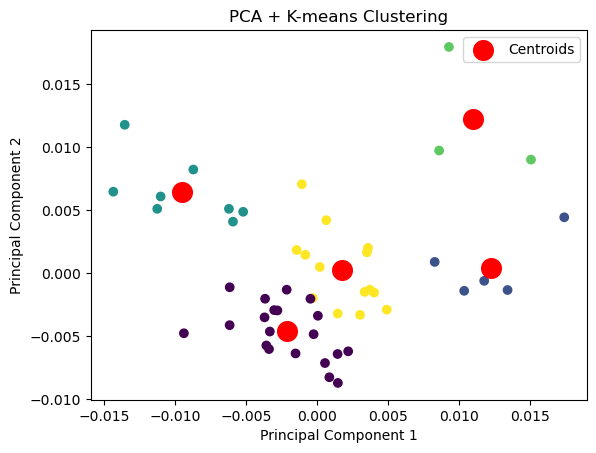

In [11]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 加载因子暴露值数据
factor_exposures = pd.read_csv("factor_exposures.csv", index_col=0)

# 清理数据，移除包含 NaN 的股票
factor_exposures = factor_exposures.dropna()

# 使用 PCA 降维
pca = PCA(n_components=2)  # 降到 2 维
reduced_data = pca.fit_transform(factor_exposures)

# 打印 PCA 解释的方差比例
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# 使用 K-means 进行聚类
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# 将聚类结果添加到原数据中
factor_exposures['Cluster'] = clusters

# 保存聚类结果
factor_exposures.to_csv("clustered_factor_exposures.csv")

# 可视化聚类结果
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("PCA + K-means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [12]:
cluster_summary = factor_exposures.groupby('Cluster').mean()
print(cluster_summary)


            const    Market      Size     Value
Cluster                                        
0       -0.098662  0.007858 -0.000492  0.004026
1       -0.085707  0.013248  0.002795 -0.001250
2       -0.104425  0.013336  0.008111  0.010389
3       -0.084574  0.018318  0.011719  0.005453
4       -0.094766  0.011628  0.002647  0.003982


In [13]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    print(f"Silhouette Score for k={k}: {score}")


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=2: 0.48556924147235464


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=3: 0.4932754524107065


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=4: 0.411866824170658


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=5: 0.3880886935985626


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=6: 0.3995609643235884


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=7: 0.4032754037129446


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=8: 0.4105755285841156


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for k=9: 0.4161956489321


Explained variance ratio: [0.48888926 0.31910505]


D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


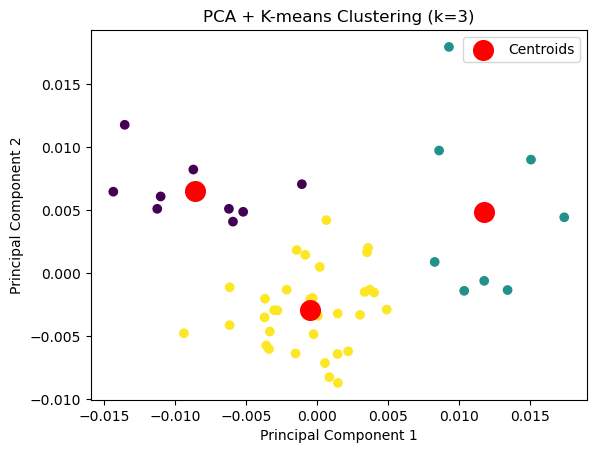

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 加载因子暴露值数据
factor_exposures = pd.read_csv("factor_exposures.csv", index_col=0)

# 清理数据，移除包含 NaN 的股票
factor_exposures = factor_exposures.dropna()

# 使用 PCA 降维
pca = PCA(n_components=2)  # 降到 2 维
reduced_data = pca.fit_transform(factor_exposures)

# 打印 PCA 解释的方差比例
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# 使用 K-means 进行聚类（k=3）
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# 将聚类结果添加到原数据中
factor_exposures['Cluster'] = clusters

# 保存聚类结果
factor_exposures.to_csv("clustered_factor_exposures_k3.csv")

# 可视化聚类结果
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("PCA + K-means Clustering (k=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [15]:
cluster_summary_k3 = factor_exposures.groupby('Cluster').mean()
print(cluster_summary_k3)


            const    Market      Size     Value
Cluster                                        
0       -0.103661  0.013576  0.008163  0.009830
1       -0.085283  0.015149  0.006142  0.001263
2       -0.097043  0.009226  0.000565  0.003967


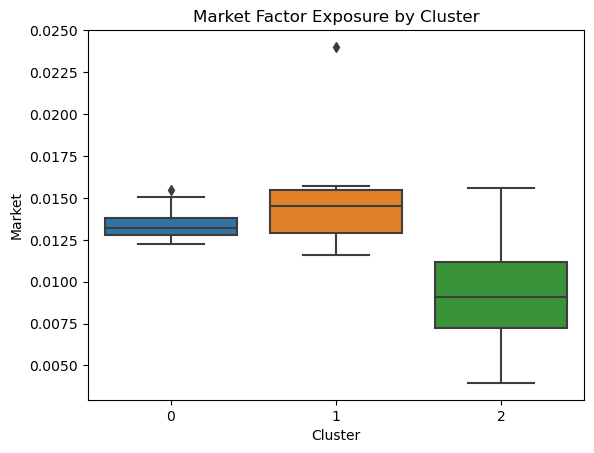

2    33
0     9
1     8
Name: Cluster, dtype: int64


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Cluster', y='Market', data=factor_exposures)
plt.title('Market Factor Exposure by Cluster')
plt.show()
cluster_counts = factor_exposures['Cluster'].value_counts()
print(cluster_counts)


组合优化

In [17]:
import pandas as pd

# Step 1: 加载数据
# 加载股票月度收益率
monthly_returns = pd.read_csv("monthly_returns.csv", index_col=0, parse_dates=True)
# 加载因子暴露值
factor_exposures = pd.read_csv("factor_exposures.csv", index_col=0, parse_dates=True)
# 加载 Fama-French 因子数据（包括 Risk-Free）
fama_french_factors = pd.read_csv("processed_fama_french_factors.csv", index_col=0, parse_dates=True)
# 加载聚类结果
clustered_data = pd.read_csv("clustered_factor_exposures_k3.csv", index_col=0)
clustered_data.index.name = 'Stock'  # 确保股票名称为索引

# Step 2: 提取 Risk-Free 列
risk_free = fama_french_factors['Risk-Free']

# Step 3: 计算超额收益率
excess_returns = monthly_returns.subtract(risk_free, axis=0)

# Step 4: 合并数据
# 将超额收益率与因子数据对齐
aligned_data = excess_returns.join(factor_exposures, how='inner')

# Step 5: 添加聚类结果
aligned_data = aligned_data.T  # 转置以便按股票名称合并
aligned_data = aligned_data.join(clustered_data['Cluster'], how='inner')  # 加入 Cluster 列
aligned_data = aligned_data.T  # 转回原始格式

# Step 6: 检查结果
print("Aligned Data with Cluster:")
print(aligned_data.head())

# Step 7: 保存最终文件
aligned_data.to_csv("aligned_excess_returns_and_factors_with_cluster.csv")
print("Aligned data with Cluster saved to 'aligned_excess_returns_and_factors_with_cluster.csv'")




Aligned Data with Cluster:
         MCO  BAC  AKAM  PFG  CPRT  CMS  BMY  PPG  AVB  NRG  ...  EFX  CHRW  \
Cluster    2    0     2    0     1    2    2    2    2    2  ...    2     2   

         C  WELL  QCOM  EPAM  FIS  ADSK  EXC  WAB  
Cluster  0     2     2     1    2     2    2    0  

[1 rows x 50 columns]
Aligned data with Cluster saved to 'aligned_excess_returns_and_factors_with_cluster.csv'


In [18]:
import pandas as pd

# Step 1: 加载文件 行列互换修复文件。
file_path = "aligned_excess_returns_and_factors_with_cluster.csv"
aligned_data = pd.read_csv(file_path, index_col=0)

# Step 2: 提取 Cluster 信息
clusters = aligned_data.loc['Cluster']  # 提取 Cluster 行

# 删除 Cluster 行，只保留收益率数据
aligned_data = aligned_data.drop(index='Cluster')

# 将 Cluster 添加为单独的一列
aligned_data = aligned_data.T  # 转置以便股票为行
aligned_data['Cluster'] = clusters.values  # 将 Cluster 行转为列

# Step 3: 保存修复后的文件
aligned_data.to_csv("aligned_excess_returns_and_factors_with_cluster_fixed.csv")
print("Cluster row fixed and saved to 'aligned_excess_returns_and_factors_with_cluster_fixed.csv'")




Cluster row fixed and saved to 'aligned_excess_returns_and_factors_with_cluster_fixed.csv'


In [19]:
# 加载收益率数据
returns_file_path = "monthly_returns.csv"  # 请根据实际文件路径调整
returns_data = pd.read_csv(returns_file_path, index_col=0, parse_dates=True)

# 加载股票的 Cluster 信息
clusters_file_path = "aligned_excess_returns_and_factors_with_cluster_fixed.csv"
clusters_data = pd.read_csv(clusters_file_path, index_col=0)

# 检查文件内容
print("Returns Data:")
print(returns_data.head())

print("\nClusters Data:")
print(clusters_data.head())



Returns Data:
                 MCO       BAC      AKAM       PFG      CPRT       CMS  \
Date                                                                     
2014-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2014-02-01  0.059265 -0.013134  0.282089  0.040854  0.062719  0.023030   
2014-03-01  0.004051  0.040532 -0.047767  0.014113 -0.001098  0.029898   
2014-04-01 -0.010338 -0.119767 -0.088301  0.018482 -0.003298  0.035178   
2014-05-01  0.089682  0.000000  0.023931 -0.001494 -0.019300 -0.018476   

                 BMY       PPG       AVB       NRG  ...       EFX      CHRW  \
Date                                                ...                       
2014-01-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2014-02-01  0.076046  0.084777  0.044292  0.043806  ...  0.000000 -0.114110   
2014-03-01 -0.033848 -0.022040  0.018221  0.093911  ... -0.028975  0.010220   
2014-04-01 -0.035804  0.000827  0.039826  0.028931  ...  0.040864  0.124

In [20]:
# 添加 Cluster 信息到收益率数据
returns_data_with_cluster = returns_data.T
returns_data_with_cluster['Cluster'] = clusters_data['Cluster']
returns_data_with_cluster = returns_data_with_cluster.T

# 保存新的数据文件
merged_file_path = "aligned_returns_and_clusters.csv"
returns_data_with_cluster.to_csv(merged_file_path)

print(f"Aligned returns and clusters saved to {merged_file_path}")


Aligned returns and clusters saved to aligned_returns_and_clusters.csv


In [21]:
import pandas as pd

# 加载数据
file_path = "aligned_returns_and_clusters.csv"
data = pd.read_csv(file_path, index_col=0)

# 提取簇信息（最后一行）
clusters = data.iloc[-1]  # 最后一行是簇
clusters = clusters.astype(int)  # 转换为整数

# 删除簇信息行，保留收益率数据
returns_data = data.iloc[:-1]

# 检查数据
print("Clusters Data:")
print(clusters.head())

print("\nReturns Data (First 5 Rows):")
print(returns_data.head())


Clusters Data:
MCO     2
BAC     0
AKAM    2
PFG     0
CPRT    1
Name: Cluster, dtype: int32

Returns Data (First 5 Rows):
                          MCO       BAC      AKAM       PFG      CPRT  \
Date                                                                    
2014-01-01 00:00:00       NaN       NaN       NaN       NaN       NaN   
2014-02-01 00:00:00  0.059265 -0.013134  0.282089  0.040854  0.062719   
2014-03-01 00:00:00  0.004051  0.040532 -0.047767  0.014113 -0.001098   
2014-04-01 00:00:00 -0.010338 -0.119767 -0.088301  0.018482 -0.003298   
2014-05-01 00:00:00  0.089682  0.000000  0.023931 -0.001494 -0.019300   

                          CMS       BMY       PPG       AVB       NRG  ...  \
Date                                                                   ...   
2014-01-01 00:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2014-02-01 00:00:00  0.023030  0.076046  0.084777  0.044292  0.043806  ...   
2014-03-01 00:00:00  0.029898 -0.033848 -0.022040  0.

In [22]:
from scipy.optimize import minimize
import numpy as np

# 定义优化函数
def portfolio_volatility(weights, cov_matrix):
    """计算投资组合的波动率"""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def weight_constraint(weights):
    """权重和必须为1"""
    return np.sum(weights) - 1

# 针对每个簇进行优化并保存结果
optimal_weights_per_cluster = {}
for cluster_id in clusters.unique():
    print(f"\nProcessing cluster {cluster_id}...")

    # 提取属于该簇的股票
    cluster_stocks = clusters[clusters == cluster_id].index
    cluster_data = returns_data[cluster_stocks]

    if cluster_data.empty:
        print(f"Cluster {cluster_id} has no valid data. Skipping.")
        continue

    # 计算均值和协方差矩阵
    mean_returns = cluster_data.mean()
    cov_matrix = cluster_data.cov()

    # 初始化优化设置
    num_assets = len(mean_returns)
    initial_weights = np.array([1 / num_assets] * num_assets)
    bounds = [(0, 1) for _ in range(num_assets)]
    constraints = ({'type': 'eq', 'fun': weight_constraint})

    # 优化权重
    optimized = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
                         method='SLSQP', bounds=bounds, constraints=constraints)

    if optimized.success:
        optimal_weights = pd.Series(optimized.x, index=cluster_stocks)
        optimal_weights_per_cluster[cluster_id] = optimal_weights

        # 保存每个簇的权重到 CSV 文件
        output_file = f"cluster_{cluster_id}_optimal_weights.csv"
        optimal_weights.to_csv(output_file, header=["Weight"])
        print(f"Cluster {cluster_id} optimal weights saved to {output_file}")
    else:
        print(f"Optimization failed for cluster {cluster_id}: {optimized.message}")





Processing cluster 2...
Cluster 2 optimal weights saved to cluster_2_optimal_weights.csv

Processing cluster 0...
Cluster 0 optimal weights saved to cluster_0_optimal_weights.csv

Processing cluster 1...
Cluster 1 optimal weights saved to cluster_1_optimal_weights.csv


In [23]:
# 跨簇优化
print("\nProcessing all clusters together (cross-cluster optimization)...")

# 使用所有股票
all_stocks = returns_data.columns
all_data = returns_data[all_stocks]

# 计算均值和协方差矩阵
mean_returns = all_data.mean()
cov_matrix = all_data.cov()

# 初始化优化设置
num_assets = len(mean_returns)
initial_weights = np.array([1 / num_assets] * num_assets)
bounds = [(0, 1) for _ in range(num_assets)]
constraints = ({'type': 'eq', 'fun': weight_constraint})

# 优化权重
optimized = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)

if optimized.success:
    optimal_weights = pd.Series(optimized.x, index=all_stocks)

    # 保存跨簇权重结果到 CSV 文件
    output_file = "cross_cluster_optimal_weights.csv"
    optimal_weights.to_csv(output_file, header=["Weight"])
    print(f"Cross-cluster optimal weights saved to {output_file}")
else:
    print(f"Optimization failed: {optimized.message}")



Processing all clusters together (cross-cluster optimization)...
Cross-cluster optimal weights saved to cross_cluster_optimal_weights.csv


结果验证

In [24]:
import pandas as pd

# Step 1: 加载数据
file_path = "aligned_returns_and_clusters.csv"  # 替换为你的文件路径
data = pd.read_csv(file_path, index_col=0)

# Step 2: 提取簇信息（最后一行）
clusters = data.iloc[-1]
clusters.name = "Cluster"  # 重命名索引为 "Cluster"

# 删除最后一行，保留收益率数据
returns_data = data.iloc[:-1]

# Step 3: 转置收益率数据为 "行: 时间, 列: 股票"
returns_data.index.name = "Date"
returns_data = returns_data.T  # 转置数据，使股票为行，时间为列

# Step 4: 保存调整后的文件
returns_file = "processed_returns.csv"
clusters_file = "processed_clusters.csv"

returns_data.to_csv(returns_file)
clusters.to_csv(clusters_file, header=True)

print(f"收益率文件已保存: {returns_file}")
print(f"簇信息文件已保存: {clusters_file}")


收益率文件已保存: processed_returns.csv
簇信息文件已保存: processed_clusters.csv


In [25]:
import pandas as pd

# 加载文件
aligned_data = pd.read_csv("aligned_returns_and_clusters.csv", index_col=0)

# 检查文件结构
print("Data Columns (should be stocks):", aligned_data.columns[:5])
print("Data Index (should be dates):", aligned_data.index[:5])

# 将最后一行提取为簇信息
clusters = aligned_data.iloc[-1].astype(int)
returns_data = aligned_data.iloc[:-1]

# 确认数据调整后格式
print("Adjusted Returns Data (first 5 rows):\n", returns_data.head())
print("Adjusted Clusters Data (first 5 rows):\n", clusters.head())



Data Columns (should be stocks): Index(['MCO', 'BAC', 'AKAM', 'PFG', 'CPRT'], dtype='object')
Data Index (should be dates): Index(['2014-01-01 00:00:00', '2014-02-01 00:00:00', '2014-03-01 00:00:00',
       '2014-04-01 00:00:00', '2014-05-01 00:00:00'],
      dtype='object', name='Date')
Adjusted Returns Data (first 5 rows):
                           MCO       BAC      AKAM       PFG      CPRT  \
Date                                                                    
2014-01-01 00:00:00       NaN       NaN       NaN       NaN       NaN   
2014-02-01 00:00:00  0.059265 -0.013134  0.282089  0.040854  0.062719   
2014-03-01 00:00:00  0.004051  0.040532 -0.047767  0.014113 -0.001098   
2014-04-01 00:00:00 -0.010338 -0.119767 -0.088301  0.018482 -0.003298   
2014-05-01 00:00:00  0.089682  0.000000  0.023931 -0.001494 -0.019300   

                          CMS       BMY       PPG       AVB       NRG  ...  \
Date                                                                   ...   
2014

In [26]:
# 确保返回数据和簇分配中的股票一致
returns_stocks = set(returns_data.columns)
cluster_stocks = set(clusters.index)

# 检查公共股票
common_stocks = returns_stocks & cluster_stocks
missing_in_returns = cluster_stocks - returns_stocks
missing_in_clusters = returns_stocks - cluster_stocks

print(f"Common stocks: {len(common_stocks)}")
print(f"Stocks in clusters but not in returns data: {missing_in_returns}")
print(f"Stocks in returns data but not in clusters: {missing_in_clusters}")

# 保留公共股票
returns_data = returns_data[list(common_stocks)]
clusters = clusters.loc[list(common_stocks)]




Common stocks: 50
Stocks in clusters but not in returns data: set()
Stocks in returns data but not in clusters: set()


In [27]:
# 保存调整后的数据
returns_data.to_csv("processed_returns_data.csv")
clusters.to_csv("processed_clusters_data.csv")
print("Adjusted data saved.")



Adjusted data saved.


In [28]:
import pandas as pd

# 读取调整后的收益率和簇数据
returns_data = pd.read_csv("processed_returns_data.csv", index_col=0, parse_dates=True)
clusters = pd.read_csv("processed_clusters_data.csv", index_col=0, squeeze=True)

# 初始化存储各簇收益率的 DataFrame
portfolio_returns_per_cluster = pd.DataFrame(index=returns_data.index)

# 遍历每个簇
for cluster_id in clusters.unique():
    print(f"Processing Cluster {cluster_id}...")
    
    # 提取属于该簇的股票
    cluster_stocks = clusters[clusters == cluster_id].index
    
    # 读取该簇的权重
    weights_file = f"cluster_{cluster_id}_optimal_weights.csv"
    try:
        weights = pd.read_csv(weights_file, index_col=0, squeeze=True)
    except FileNotFoundError:
        print(f"Weight file for cluster {cluster_id} not found. Skipping...")
        continue
    
    # 计算该簇的投资组合收益率
    cluster_returns = returns_data[cluster_stocks]
    portfolio_returns = (cluster_returns * weights).sum(axis=1)
    
    # 添加到结果 DataFrame
    portfolio_returns_per_cluster[f"Cluster_{cluster_id}_Returns"] = portfolio_returns

# 保存所有簇的收益率
portfolio_returns_per_cluster.to_csv("portfolio_returns_per_cluster.csv")
print("Cluster portfolio returns saved to 'portfolio_returns_per_cluster.csv'")


Processing Cluster 2...
Processing Cluster 0...
Processing Cluster 1...
Cluster portfolio returns saved to 'portfolio_returns_per_cluster.csv'


C:\Users\ROG\AppData\Local\Temp\ipykernel_38980\3350422609.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  clusters = pd.read_csv("processed_clusters_data.csv", index_col=0, squeeze=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_38980\3350422609.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  weights = pd.read_csv(weights_file, index_col=0, squeeze=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_38980\3350422609.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  weights = pd.read_csv(weights_file, index_col=0, squeeze=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_38980\3350422609.py:20: FutureWarning: The squeeze argument has been deprecated and will be remove

In [29]:
import pandas as pd

# 加载数据
returns_data = pd.read_csv("monthly_returns.csv", index_col=0, parse_dates=True)
sp500_data = pd.read_csv("sp500_data.csv", index_col=0, parse_dates=True)

# 确保时间索引是 datetime 格式，并移除时区信息
returns_data.index = pd.to_datetime(returns_data.index, errors='coerce').tz_localize(None)
sp500_data.index = pd.to_datetime(sp500_data.index, errors='coerce').tz_localize(None)

# 删除无效日期
returns_data.dropna(inplace=True)
sp500_data.dropna(inplace=True)

# 对齐日期索引，获取公共日期范围
common_dates = returns_data.index.intersection(sp500_data.index)
returns_data = returns_data.loc[common_dates]
sp500_data = sp500_data.loc[common_dates]

print("Aligned Returns Data Index:", returns_data.index)
print("Aligned S&P 500 Data Index:", sp500_data.index)


Aligned Returns Data Index: DatetimeIndex(['2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=106, freq=None)
Aligned S&P 500 Data Index: DatetimeIndex(['2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=106, freq=None)


In [30]:
import numpy as np

# 定义计算指标的函数
def calculate_sharpe_ratio(returns, risk_free_rate=0.001):
    """计算夏普比率"""
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

def calculate_information_ratio(returns, benchmark_returns):
    """计算信息比率"""
    active_returns = returns - benchmark_returns
    return active_returns.mean() / active_returns.std()

def calculate_max_drawdown(returns):
    """计算最大回撤"""
    cumulative_returns = (1 + returns).cumprod()
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    return drawdown.min()

# 计算指标
sharpe_ratio = calculate_sharpe_ratio(returns_data.mean(axis=1))
information_ratio = calculate_information_ratio(returns_data.mean(axis=1), sp500_data['Monthly Return'])
max_drawdown = calculate_max_drawdown(returns_data.mean(axis=1))

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Information Ratio: {information_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Sharpe Ratio: 0.21
Information Ratio: 0.18
Maximum Drawdown: -25.16%


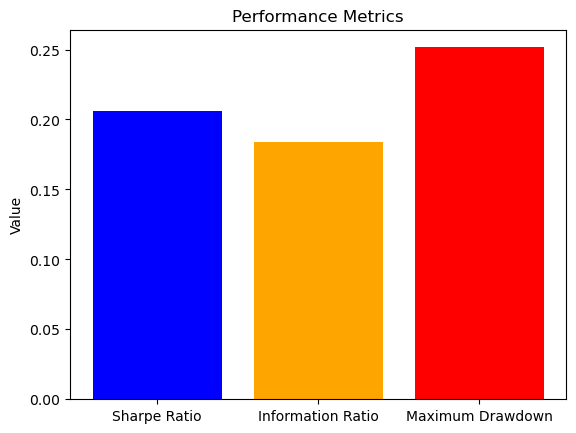

In [31]:
import matplotlib.pyplot as plt


# 夏普比率和最大回撤柱状图
metrics = ['Sharpe Ratio', 'Information Ratio', 'Maximum Drawdown']
values = [sharpe_ratio, information_ratio, abs(max_drawdown)]  # 取绝对值便于展示

plt.bar(metrics, values, color=['blue', 'orange', 'red'])
plt.title("Performance Metrics")
plt.ylabel("Value")
plt.show()


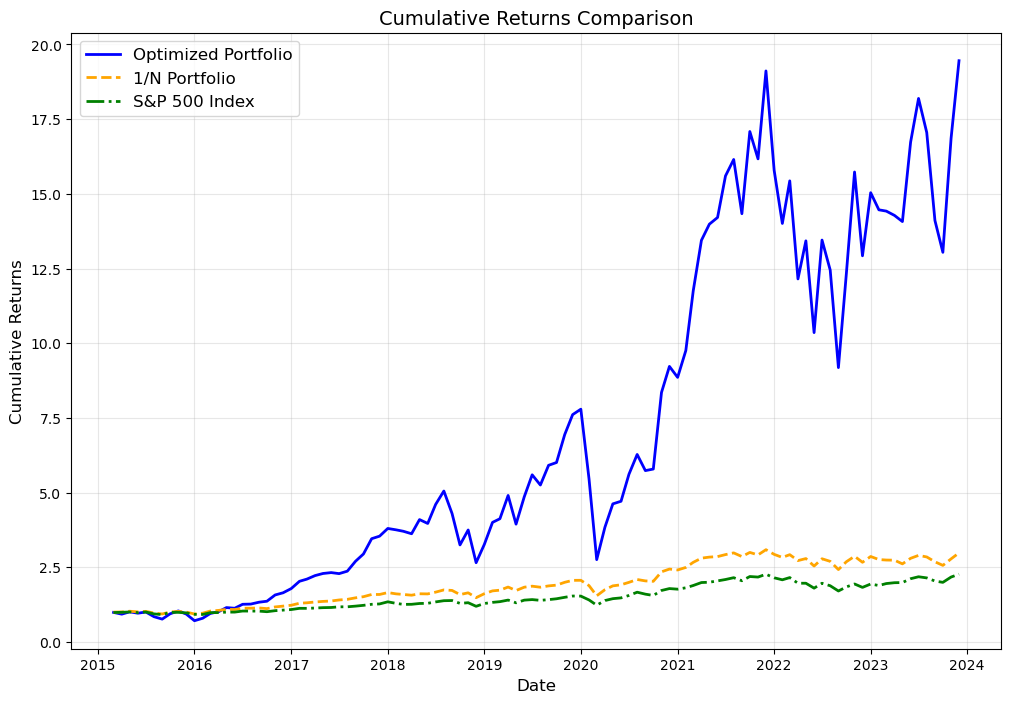

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure time indexes are consistent and aligned
aligned_index = returns_data.index.intersection(sp500_data.index)
returns_data = returns_data.loc[aligned_index]
sp500_data = sp500_data.loc[aligned_index]

# Calculate 1/N portfolio returns
num_assets = returns_data.shape[1]  # Number of stocks
equal_weights = np.ones(num_assets) / num_assets  # Equal weights
returns_1n = (returns_data * equal_weights).sum(axis=1)  # 1/N portfolio returns
cumulative_returns_1n = (1 + returns_1n).cumprod()

# Calculate optimized portfolio cumulative returns
# Assuming you already have `optimized_weights`
optimized_weights = pd.read_csv("combined_optimized_weights.csv", index_col=0)['Weight']
returns_optimized = (returns_data * optimized_weights).sum(axis=1)
cumulative_returns_optimized = (1 + returns_optimized).cumprod()

# Calculate S&P 500 cumulative returns
cumulative_returns_sp500 = (1 + sp500_data['Monthly Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_optimized, label="Optimized Portfolio", color="blue", linewidth=2)
plt.plot(cumulative_returns_1n, label="1/N Portfolio", color="orange", linestyle="--", linewidth=2)
plt.plot(cumulative_returns_sp500, label="S&P 500 Index", color="green", linestyle="-.", linewidth=2)

# Add titles, labels, and legend
plt.title("Cumulative Returns Comparison", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.3)

plt.show()
